In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=load_path,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = Adam(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [2]:
def heartnet_transfer(load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=load_path,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
#     x = model.layers[-4].output
#     x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
#     x = Dropout(rate=dropout_rate,seed=1) (x)
#     x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
#     x = Dropout(rate=dropout_rate, seed=1)(x)
#     output = Dense(3,activation='softmax')(x)
#     model = Model(inputs=model.input,outputs=output)
#     plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = Adam(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
class log_recall(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

            confmat = confusion_matrix(y_pred=pred, y_true=true)
            
            logs['recall0'] = confmat[0,0]/np.sum(confmat[0,:])
            logs['recall1'] = confmat[1,1]/np.sum(confmat[1,:])
            logs['recall2'] = confmat[2,2]/np.sum(confmat[2,:])
            logs['UAR'] = np.mean([logs['recall0'],logs['recall1'],logs['recall2']])

In [35]:
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

##### Load Model ######
load_path='/media/taufiq/Data1/heart_sound/weights.0169-0.8798.hdf5'
# lr = 0.00001
lr = 1e-6
num_dense1 = 239 #34,120,167,239,1239,650,788,422,598
num_dense2 = 137 #121,
epochs = 40
batch_size = 256
dropout_rate = 0.
trainable = False
addweights = True

In [29]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
# y_train = to_categorical(y_train,num_classes=3)
# y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [31]:
np.sum((y_val),axis=-2)

array([1134., 4738.])

In [30]:
## relabel to 2 class
for idx in range(x_val.shape[0]):
    if y_val[idx,0] == 2:
        y_val[idx,0]=1
y_val = to_categorical(y_val)

In [36]:
model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)

In [46]:
plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
y_pred = model.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=-1)
y_val_ = np.transpose(np.argmax(y_val, axis=-1))
true = []
pred = []
start_idx = 0
for s in val_parts:

    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

    temp_ = y_val_[start_idx:start_idx + int(s) - 1]
    temp = y_pred[start_idx:start_idx + int(s) - 1]

    if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
        pred.append(0)
    elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
        pred.append(2)
    else:
        pred.append(1)

    if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
        true.append(0)
    elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
        true.append(2)
    else:
        true.append(1)

    start_idx = start_idx + int(s)

print(np.sum(to_categorical(pred),axis=-2))
confmat = confusion_matrix(y_pred=pred, y_true=true)
print(confmat)
print(103/148)

5872/5872 [==============================] - 1s 138us/step
[ 55. 125.]
[[ 10  22]
 [ 45 103]]
0.695945945946


In [7]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
#     lr = args['lr']
#     num_dense1 = args['num_dense1']
    num_dense2 = args['num_dense2']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str(args.values())
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_recall(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
#     print("History : %s" % history.history)
    loss = history.history['val_loss']
    print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': np.min(loss), 'status': STATUS_OK}

In [8]:
space = {
#     'lr' : 10 ** hp.uniform('lr',-8,-3),
#     'num_dense1' : 200 + hp.randint('num_dense1',1800),
    'num_dense2' : 40 + hp.randint('num_dense2',360)
}


In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=20)
print('best:', best)

args {'num_dense2': 89}
Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 5s - loss: 1.2428 - acc: 0.3390 - val_loss: 1.1510 - val_acc: 0.3442
Epoch 2/40
 - 4s - loss: 1.2202 - acc: 0.3444 - val_loss: 1.1484 - val_acc: 0.3360
Epoch 3/40
 - 4s - loss: 1.2046 - acc: 0.3426 - val_loss: 1.1463 - val_acc: 0.3399
Epoch 4/40
 - 4s - loss: 1.1864 - acc: 0.3595 - val_loss: 1.1439 - val_acc: 0.3408
Epoch 5/40
 - 4s - loss: 1.1795 - acc: 0.3653 - val_loss: 1.1423 - val_acc: 0.3394
Epoch 6/40
 - 4s - loss: 1.1674 - acc: 0.3720 - val_loss: 1.1429 - val_acc: 0.3374
Epoch 7/40
 - 4s - loss: 1.1539 - acc: 0.3764 - val_loss: 1.1410 - val_acc: 0.3377
Epoch 8/40
 - 4s - loss: 1.1493 - acc: 0.3775 - val_loss: 1.1421 - val_acc: 0.3338
Epoch 9/40
 - 4s - loss: 1.1350 - acc: 0.3887 - val_loss: 1.1406 - val_acc: 0.3374
Epoch 10/40
 - 4s - loss: 1.1342 - acc: 0.3859 - val_loss: 1.1411 - val_acc: 0.3362
Epoch 11/40


Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.3729 - acc: 0.3352 - val_loss: 1.1903 - val_acc: 0.2815
Epoch 2/40
 - 4s - loss: 1.3121 - acc: 0.3320 - val_loss: 1.1896 - val_acc: 0.2679
Epoch 3/40
 - 4s - loss: 1.2826 - acc: 0.3389 - val_loss: 1.1802 - val_acc: 0.2778
Epoch 4/40
 - 4s - loss: 1.2723 - acc: 0.3369 - val_loss: 1.1766 - val_acc: 0.2822
Epoch 5/40
 - 4s - loss: 1.2425 - acc: 0.3523 - val_loss: 1.1711 - val_acc: 0.2885
Epoch 6/40
 - 4s - loss: 1.2321 - acc: 0.3577 - val_loss: 1.1676 - val_acc: 0.2927
Epoch 7/40
 - 4s - loss: 1.2228 - acc: 0.3706 - val_loss: 1.1659 - val_acc: 0.2924
Epoch 8/40
 - 4s - loss: 1.2016 - acc: 0.3713 - val_loss: 1.1642 - val_acc: 0.2950
Epoch 9/40
 - 4s - loss: 1.1983 - acc: 0.3724 - val_loss: 1.1614 - val_acc: 0.3026
Epoch 10/40
 - 4s - loss: 1.1803 - acc: 0.3855 - val_loss: 1.1622 - val_acc: 0.3016
Epoch 11/40
 - 4s - loss: 1.1726 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.3332 - acc: 0.3295 - val_loss: 1.1653 - val_acc: 0.3261
Epoch 2/40
 - 4s - loss: 1.2918 - acc: 0.3303 - val_loss: 1.1609 - val_acc: 0.3372
Epoch 3/40
 - 4s - loss: 1.2730 - acc: 0.3421 - val_loss: 1.1578 - val_acc: 0.3421
Epoch 4/40
 - 4s - loss: 1.2470 - acc: 0.3568 - val_loss: 1.1549 - val_acc: 0.3472
Epoch 5/40
 - 4s - loss: 1.2276 - acc: 0.3656 - val_loss: 1.1574 - val_acc: 0.3478
Epoch 6/40
 - 4s - loss: 1.2160 - acc: 0.3704 - val_loss: 1.1515 - val_acc: 0.3583
Epoch 7/40
 - 4s - loss: 1.2025 - acc: 0.3802 - val_loss: 1.1528 - val_acc: 0.3575
Epoch 8/40
 - 4s - loss: 1.1902 - acc: 0.3848 - val_loss: 1.1523 - val_acc: 0.3622
Epoch 9/40
 - 4s - loss: 1.1777 - acc: 0.3860 - val_loss: 1.1514 - val_acc: 0.3617
Epoch 10/40
 - 4s - loss: 1.1800 - acc: 0.3891 - val_loss: 1.1482 - val_acc: 0.3650
Epoch 11/40
 - 4s - loss: 1.1570 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.3184 - acc: 0.2633 - val_loss: 1.1358 - val_acc: 0.3466
Epoch 2/40
 - 4s - loss: 1.2625 - acc: 0.3150 - val_loss: 1.1140 - val_acc: 0.3902
Epoch 3/40
 - 4s - loss: 1.2468 - acc: 0.3349 - val_loss: 1.1078 - val_acc: 0.3976
Epoch 4/40
 - 4s - loss: 1.2210 - acc: 0.3466 - val_loss: 1.1050 - val_acc: 0.4009
Epoch 5/40
 - 4s - loss: 1.2081 - acc: 0.3490 - val_loss: 1.1027 - val_acc: 0.4065
Epoch 6/40
 - 4s - loss: 1.1975 - acc: 0.3594 - val_loss: 1.1031 - val_acc: 0.4063
Epoch 7/40
 - 4s - loss: 1.1814 - acc: 0.3709 - val_loss: 1.1026 - val_acc: 0.4070
Epoch 8/40
 - 4s - loss: 1.1692 - acc: 0.3757 - val_loss: 1.1039 - val_acc: 0.4028
Epoch 9/40
 - 4s - loss: 1.1686 - acc: 0.3803 - val_loss: 1.1040 - val_acc: 0.4036
Epoch 10/40
 - 4s - loss: 1.1539 - acc: 0.3882 - val_loss: 1.1054 - val_acc: 0.4004
Epoch 11/40
 - 4s - loss: 1.1481 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.4384 - acc: 0.3766 - val_loss: 1.1710 - val_acc: 0.3406
Epoch 2/40
 - 4s - loss: 1.3104 - acc: 0.3668 - val_loss: 1.1803 - val_acc: 0.3106
Epoch 3/40
 - 4s - loss: 1.2751 - acc: 0.3517 - val_loss: 1.1841 - val_acc: 0.2997
Epoch 4/40
 - 4s - loss: 1.2543 - acc: 0.3589 - val_loss: 1.1871 - val_acc: 0.2951
Epoch 5/40
 - 4s - loss: 1.2556 - acc: 0.3523 - val_loss: 1.1818 - val_acc: 0.2980
Epoch 6/40
 - 4s - loss: 1.2306 - acc: 0.3645 - val_loss: 1.1770 - val_acc: 0.3042
Epoch 7/40
 - 4s - loss: 1.2183 - acc: 0.3692 - val_loss: 1.1781 - val_acc: 0.3007
Epoch 8/40
 - 4s - loss: 1.1958 - acc: 0.3738 - val_loss: 1.1757 - val_acc: 0.3050
Epoch 9/40
 - 4s - loss: 1.1935 - acc: 0.3821 - val_loss: 1.1715 - val_acc: 0.3099
Epoch 10/40
 - 4s - loss: 1.1845 - acc: 0.3879 - val_loss: 1.1724 - val_acc: 0.3077
Epoch 11/40
 - 4s - loss: 1.1638 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.3214 - acc: 0.2963 - val_loss: 1.1791 - val_acc: 0.2868
Epoch 2/40
 - 4s - loss: 1.2805 - acc: 0.3353 - val_loss: 1.1639 - val_acc: 0.3001
Epoch 3/40
 - 4s - loss: 1.2487 - acc: 0.3500 - val_loss: 1.1540 - val_acc: 0.3094
Epoch 4/40
 - 4s - loss: 1.2265 - acc: 0.3680 - val_loss: 1.1468 - val_acc: 0.3162
Epoch 5/40
 - 4s - loss: 1.2112 - acc: 0.3736 - val_loss: 1.1431 - val_acc: 0.3181
Epoch 6/40
 - 4s - loss: 1.1946 - acc: 0.3750 - val_loss: 1.1407 - val_acc: 0.3232
Epoch 7/40
 - 4s - loss: 1.1848 - acc: 0.3792 - val_loss: 1.1365 - val_acc: 0.3270
Epoch 8/40
 - 4s - loss: 1.1714 - acc: 0.3871 - val_loss: 1.1351 - val_acc: 0.3336
Epoch 9/40
 - 4s - loss: 1.1640 - acc: 0.3923 - val_loss: 1.1322 - val_acc: 0.3369
Epoch 10/40
 - 4s - loss: 1.1507 - acc: 0.3955 - val_loss: 1.1299 - val_acc: 0.3443
Epoch 11/40
 - 4s - loss: 1.1413 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.4760 - acc: 0.4445 - val_loss: 1.1077 - val_acc: 0.4091
Epoch 2/40
 - 4s - loss: 1.3078 - acc: 0.3937 - val_loss: 1.1465 - val_acc: 0.3421
Epoch 3/40
 - 4s - loss: 1.2692 - acc: 0.3661 - val_loss: 1.1650 - val_acc: 0.3147
Epoch 4/40
 - 4s - loss: 1.2489 - acc: 0.3476 - val_loss: 1.1696 - val_acc: 0.3106
Epoch 5/40
 - 4s - loss: 1.2308 - acc: 0.3607 - val_loss: 1.1663 - val_acc: 0.3132
Epoch 6/40
 - 4s - loss: 1.2171 - acc: 0.3673 - val_loss: 1.1693 - val_acc: 0.3082
Epoch 7/40
 - 4s - loss: 1.2131 - acc: 0.3645 - val_loss: 1.1676 - val_acc: 0.3101
Epoch 8/40
 - 4s - loss: 1.2038 - acc: 0.3724 - val_loss: 1.1685 - val_acc: 0.3128
Epoch 9/40
 - 4s - loss: 1.1929 - acc: 0.3737 - val_loss: 1.1669 - val_acc: 0.3123
Epoch 10/40
 - 4s - loss: 1.1797 - acc: 0.3758 - val_loss: 1.1669 - val_acc: 0.3132
Epoch 11/40
 - 4s - loss: 1.1652 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.4062 - acc: 0.2966 - val_loss: 1.1801 - val_acc: 0.3035
Epoch 2/40
 - 4s - loss: 1.3113 - acc: 0.3471 - val_loss: 1.1593 - val_acc: 0.3333
Epoch 3/40
 - 4s - loss: 1.2850 - acc: 0.3578 - val_loss: 1.1508 - val_acc: 0.3452
Epoch 4/40
 - 4s - loss: 1.2689 - acc: 0.3606 - val_loss: 1.1465 - val_acc: 0.3445
Epoch 5/40
 - 4s - loss: 1.2415 - acc: 0.3709 - val_loss: 1.1399 - val_acc: 0.3491
Epoch 6/40
 - 4s - loss: 1.2300 - acc: 0.3725 - val_loss: 1.1358 - val_acc: 0.3532
Epoch 7/40
 - 4s - loss: 1.2147 - acc: 0.3796 - val_loss: 1.1346 - val_acc: 0.3530
Epoch 8/40
 - 4s - loss: 1.1933 - acc: 0.3868 - val_loss: 1.1311 - val_acc: 0.3587
Epoch 9/40
 - 4s - loss: 1.1835 - acc: 0.3948 - val_loss: 1.1292 - val_acc: 0.3622
Epoch 10/40
 - 4s - loss: 1.1730 - acc: 0.4020 - val_loss: 1.1290 - val_acc: 0.3583
Epoch 11/40
 - 4s - loss: 1.1624 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 4s - loss: 1.4316 - acc: 0.2363 - val_loss: 1.2137 - val_acc: 0.3212
Epoch 2/40
 - 4s - loss: 1.3159 - acc: 0.3041 - val_loss: 1.1449 - val_acc: 0.3716
Epoch 3/40
 - 4s - loss: 1.2731 - acc: 0.3412 - val_loss: 1.1246 - val_acc: 0.3924
Epoch 4/40
 - 4s - loss: 1.2479 - acc: 0.3636 - val_loss: 1.1199 - val_acc: 0.3988
Epoch 5/40
 - 4s - loss: 1.2361 - acc: 0.3718 - val_loss: 1.1183 - val_acc: 0.4007
Epoch 6/40
 - 4s - loss: 1.2179 - acc: 0.3771 - val_loss: 1.1181 - val_acc: 0.4007
Epoch 7/40
 - 4s - loss: 1.2084 - acc: 0.3821 - val_loss: 1.1180 - val_acc: 0.4017
Epoch 8/40
 - 4s - loss: 1.1991 - acc: 0.3879 - val_loss: 1.1187 - val_acc: 0.3975
Epoch 9/40
 - 4s - loss: 1.1859 - acc: 0.3829 - val_loss: 1.1194 - val_acc: 0.3973
Epoch 10/40
 - 4s - loss: 1.1801 - acc: 0.3923 - val_loss: 1.1222 - val_acc: 0.3937
Epoch 11/40
 - 4s - loss: 1.1681 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/40
 - 5s - loss: 1.4941 - acc: 0.3985 - val_loss: 1.1678 - val_acc: 0.3581
Epoch 2/40
 - 4s - loss: 1.3370 - acc: 0.3881 - val_loss: 1.1748 - val_acc: 0.3219
Epoch 3/40
 - 4s - loss: 1.2821 - acc: 0.3676 - val_loss: 1.1796 - val_acc: 0.3050
Epoch 4/40
 - 4s - loss: 1.2680 - acc: 0.3581 - val_loss: 1.1818 - val_acc: 0.2967
Epoch 5/40
 - 4s - loss: 1.2471 - acc: 0.3546 - val_loss: 1.1771 - val_acc: 0.2965
Epoch 6/40
 - 4s - loss: 1.2342 - acc: 0.3662 - val_loss: 1.1739 - val_acc: 0.2955
Epoch 7/40
 - 4s - loss: 1.2163 - acc: 0.3695 - val_loss: 1.1708 - val_acc: 0.2965
Epoch 8/40
 - 4s - loss: 1.2062 - acc: 0.3765 - val_loss: 1.1697 - val_acc: 0.2973
Epoch 9/40
 - 4s - loss: 1.1912 - acc: 0.3836 - val_loss: 1.1710 - val_acc: 0.2921
Epoch 10/40
 - 4s - loss: 1.1792 - acc: 0.3842 - val_loss: 1.1644 - val_acc: 0.3013
Epoch 11/40
 - 4s - loss: 1.1610 - a

In [11]:
it=0
loss = np.zeros(len(trials))
params = np.zeros((len(trials),3))
for objects in trials.trials:
                  loss[it] = objects['result']['loss'] 
#                   params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
#                   params[it,1] = objects['misc']['vals']['num_dense1'][0]
                  params[it,2] = objects['misc']['vals']['num_dense2'][0]
                  it+=1

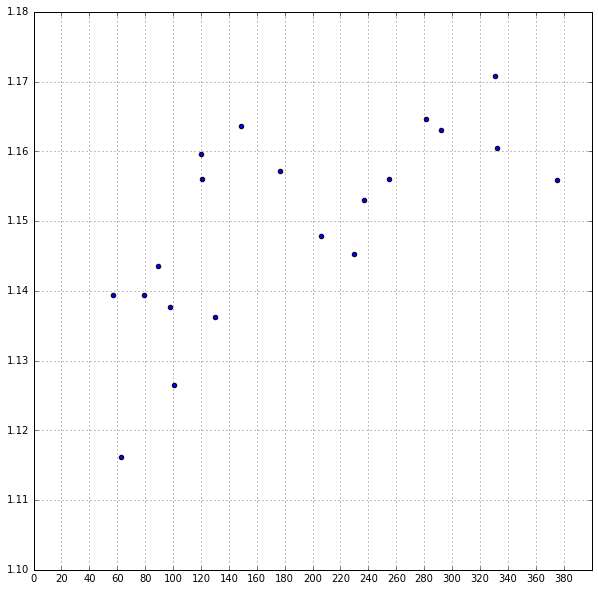

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(40 + params[:,2],loss[:])
# plt.scatter(params[:,0][mask]+200,params[:,2][mask]+20,c=loss[:][mask],s=loss[:][mask]*200)
# plt.yscale('log')
# plt.ylim([1,2])
# plt.xscale('log',nonposy='clip')
# plt.xlim([10**-8,10**-3])
# plt.colorbar()
plt.xticks(range(0,400,20))
plt.grid()
plt.show()

In [ ]:
mask = loss>0

In [17]:
trials.results

[{'loss': 1.143590560401168, 'status': 'ok'},
 {'loss': 1.1558702121963293, 'status': 'ok'},
 {'loss': 1.1635656187904628, 'status': 'ok'},
 {'loss': 1.126508028045987, 'status': 'ok'},
 {'loss': 1.1630019833021659, 'status': 'ok'},
 {'loss': 1.139373833866795, 'status': 'ok'},
 {'loss': 1.1361741551911149, 'status': 'ok'},
 {'loss': 1.1571909660214623, 'status': 'ok'},
 {'loss': 1.164590459428626, 'status': 'ok'},
 {'loss': 1.1478215797070912, 'status': 'ok'},
 {'loss': 1.1394096999467231, 'status': 'ok'},
 {'loss': 1.116140023888944, 'status': 'ok'},
 {'loss': 1.1707677617060066, 'status': 'ok'},
 {'loss': 1.145261800256672, 'status': 'ok'},
 {'loss': 1.1377046822851944, 'status': 'ok'},
 {'loss': 1.1560987867516457, 'status': 'ok'},
 {'loss': 1.1560297600255025, 'status': 'ok'},
 {'loss': 1.15963403567956, 'status': 'ok'},
 {'loss': 1.1605236955819402, 'status': 'ok'},
 {'loss': 1.1530857141401203, 'status': 'ok'}]